### Preprocesamiento

In [1]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

stop_words = stopwords.words('spanish')

# Definimos un tokenizador con Stemming
class StemmerTokenizer:
    def __init__(self):
        self.ps = SnowballStemmer('spanish')
    def __call__(self, doc):
        doc_tok = word_tokenize(doc)
        doc_tok = [t for t in doc_tok if t not in stop_words]
        return [self.ps.stem(t) for t in doc_tok]

# Inicializamos tokenizador
tokenizador = StemmerTokenizer()

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer

bog = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,2)
    )

preprocessing = ColumnTransformer(
    transformers=[('bag-of-words',bog,'comment')]
)

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline

bog_pipeline = Pipeline(
    [("Preprocessing", preprocessing),
    ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", MultinomialNB())]
)

### Cargar datos

In [4]:
from utils.cargar import df_caso

caso = 'julieta'
df = df_caso(caso)

df = df[df['comment'].notna()]
df = df[df['sel'].notna()]
df = df.drop(df[df['max_num'] > 6].index)

df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

df.head()

,sel,comment
id,,
11511,6,Si estudiaste y sabes hacer los ejercicios ¿pa...
11515,5,No debería usar la información ya que no es co...
11516,4,si es que no sabe realizar la pregunta puede r...
11517,3,lamentablemente este pais es muy injusto y la ...
11519,6,Considerando que Julieta pudo optar por una be...


In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test, y_train, y_test = train_test_split(df, df['sel'], test_size=.25, stratify=df['sel'])

In [6]:
bog_pipeline.fit(df_train,y_train)

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<__main__.StemmerTokenizer object at 0x7f8be1dbf670>),
                                                  'comment')])),
                ('Selection', SelectPercentile(percentile=90)),
                ('Clasificador', MultinomialNB())])

In [7]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)

print("Resultados clasificador Naive-Bayes multinomial")
print(classification_report(y_test, y_pred))

Resultados clasificador Naive-Bayes multinomial
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        53
           2       1.00      0.03      0.06       125
           3       0.38      0.17      0.24       219
           4       0.32      0.46      0.38       253
           5       0.27      0.51      0.36       283
           6       0.59      0.45      0.51       269

    accuracy                           0.35      1202
   macro avg       0.43      0.27      0.26      1202
weighted avg       0.44      0.35      0.33      1202



/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [8]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[  0   0   6  18  22   7]
 [  0   4  22  35  56   8]
 [  0   0  38  80  93   8]
 [  0   0  22 117 107   7]
 [  0   0   9  76 145  53]
 [  0   0   3  37 109 120]]


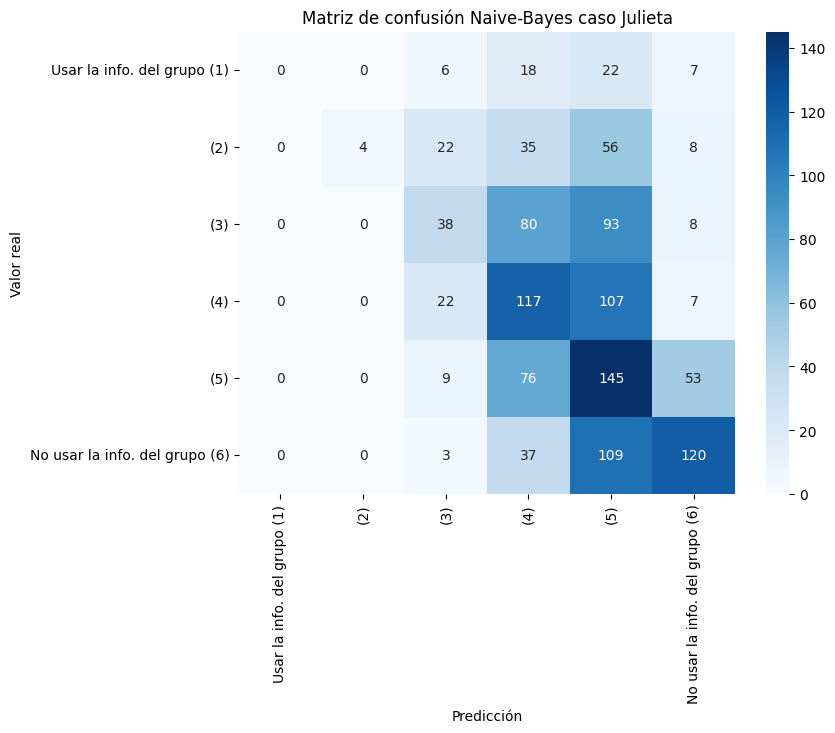

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example class labels
class_labels = ['Usar la info. del grupo (1)', '(2)', '(3)', '(4)', '(5)', 'No usar la info. del grupo (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión Naive-Bayes caso Julieta')

# Show the plot
plt.show()